In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size =3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size =3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size =3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size =3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            # nn.Conv2d(256, 512, kernel_size =3, stride=2, padding=1),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*2, 128)
        self.z_log_var = nn.Linear(512*2, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*2),
            nn.Unflatten(1, (256, 2, 2)),
            # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(256),
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size= 3, padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
1407 1407 1407


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 30

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 339.66it/s]


Epoch: 0 - TrainRecLoss: 1150.980392879006 - ValidRecLoss: 914.6926800714966
Epoch: 0 - TrainDivLoss: 80.36689033115172 - ValidDivLoss: 82.00105746282104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 351.58it/s]


Epoch: 1 - TrainRecLoss: 872.5199566307691 - ValidRecLoss: 817.9815959266169
Epoch: 1 - TrainDivLoss: 87.51808708207186 - ValidDivLoss: 90.10094793518978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 345.97it/s]


Epoch: 2 - TrainRecLoss: 809.2849389613734 - ValidRecLoss: 771.4261735104125
Epoch: 2 - TrainDivLoss: 96.02275470985786 - ValidDivLoss: 98.78056149459003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 363.34it/s]


Epoch: 3 - TrainRecLoss: 773.020185284862 - ValidRecLoss: 744.2724999141083
Epoch: 3 - TrainDivLoss: 102.33649757997992 - ValidDivLoss: 105.07016382169961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 359.30it/s]


Epoch: 4 - TrainRecLoss: 751.563337096951 - ValidRecLoss: 731.8454339326317
Epoch: 4 - TrainDivLoss: 107.20197174137336 - ValidDivLoss: 110.03720030415202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 360.54it/s]


Epoch: 5 - TrainRecLoss: 736.2218751127871 - ValidRecLoss: 713.8102261042375
Epoch: 5 - TrainDivLoss: 110.95907706644998 - ValidDivLoss: 110.96129225871202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 352.73it/s]


Epoch: 6 - TrainRecLoss: 722.6731746106938 - ValidRecLoss: 696.8142051235868
Epoch: 6 - TrainDivLoss: 114.3207228985253 - ValidDivLoss: 117.96766306342347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 346.65it/s]


Epoch: 7 - TrainRecLoss: 712.1864144244597 - ValidRecLoss: 695.9949834914435
Epoch: 7 - TrainDivLoss: 116.64396509144775 - ValidDivLoss: 119.13110699684127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 358.33it/s]


Epoch: 8 - TrainRecLoss: 703.9527295945635 - ValidRecLoss: 691.4079350605025
Epoch: 8 - TrainDivLoss: 118.47335157143621 - ValidDivLoss: 119.20147016426309


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 344.78it/s]


Epoch: 9 - TrainRecLoss: 696.7317939980621 - ValidRecLoss: 683.4187968022957
Epoch: 9 - TrainDivLoss: 120.12794285864379 - ValidDivLoss: 122.06443828916245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 365.64it/s]


Epoch: 10 - TrainRecLoss: 687.5028068363539 - ValidRecLoss: 677.0517889807727
Epoch: 10 - TrainDivLoss: 121.76189931233723 - ValidDivLoss: 121.53117457906998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 366.01it/s]


Epoch: 11 - TrainRecLoss: 682.4474479062555 - ValidRecLoss: 673.467771138379
Epoch: 11 - TrainDivLoss: 123.1544974082399 - ValidDivLoss: 121.54242136941028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 366.65it/s]


Epoch: 12 - TrainRecLoss: 676.9815359759517 - ValidRecLoss: 662.8534944991144
Epoch: 12 - TrainDivLoss: 124.2922112221572 - ValidDivLoss: 125.53722003646666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 348.53it/s]


Epoch: 13 - TrainRecLoss: 672.860028904723 - ValidRecLoss: 660.4824767285572
Epoch: 13 - TrainDivLoss: 125.3492937609924 - ValidDivLoss: 126.08173027662157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 354.73it/s]


Epoch: 14 - TrainRecLoss: 668.1927796928444 - ValidRecLoss: 658.4042711725622
Epoch: 14 - TrainDivLoss: 126.1512887950645 - ValidDivLoss: 127.1265284545725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 339.28it/s]


Epoch: 15 - TrainRecLoss: 664.9735496103467 - ValidRecLoss: 658.7031350206973
Epoch: 15 - TrainDivLoss: 126.89874535447414 - ValidDivLoss: 124.56444045814455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 353.63it/s]


Epoch: 16 - TrainRecLoss: 661.6172695742827 - ValidRecLoss: 653.9101202448971
Epoch: 16 - TrainDivLoss: 127.60788081534466 - ValidDivLoss: 126.01370891036933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 346.49it/s]


Epoch: 17 - TrainRecLoss: 658.7781860091285 - ValidRecLoss: 649.616794220166
Epoch: 17 - TrainDivLoss: 128.17751190250615 - ValidDivLoss: 128.25111505742944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 335.05it/s]


Epoch: 18 - TrainRecLoss: 656.140077961025 - ValidRecLoss: 650.2778006677688
Epoch: 18 - TrainDivLoss: 128.75804722182025 - ValidDivLoss: 126.89025576875493


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 351.55it/s]


Epoch: 19 - TrainRecLoss: 654.0212302570574 - ValidRecLoss: 646.7599055026556
Epoch: 19 - TrainDivLoss: 129.16532416435192 - ValidDivLoss: 127.86818345319996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 350.78it/s]


Epoch: 20 - TrainRecLoss: 652.0887026051383 - ValidRecLoss: 646.0637355823422
Epoch: 20 - TrainDivLoss: 129.59129657216673 - ValidDivLoss: 128.9636314299908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 366.43it/s]


Epoch: 21 - TrainRecLoss: 650.2763549761307 - ValidRecLoss: 643.6558662636871
Epoch: 21 - TrainDivLoss: 129.7931222488631 - ValidDivLoss: 128.38533109490044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 344.39it/s]


Epoch: 22 - TrainRecLoss: 648.6902042868803 - ValidRecLoss: 643.0407512260822
Epoch: 22 - TrainDivLoss: 129.90981377857156 - ValidDivLoss: 128.1808349728669


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 352.69it/s]


Epoch: 23 - TrainRecLoss: 647.3476478343495 - ValidRecLoss: 641.1505036289674
Epoch: 23 - TrainDivLoss: 130.1238432221999 - ValidDivLoss: 129.1992415405794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 363.53it/s]


Epoch: 24 - TrainRecLoss: 646.553433850037 - ValidRecLoss: 640.8121505336043
Epoch: 24 - TrainDivLoss: 130.30225109325374 - ValidDivLoss: 129.2411334180798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 344.98it/s]


Epoch: 25 - TrainRecLoss: 645.4420100078569 - ValidRecLoss: 639.7835993546497
Epoch: 25 - TrainDivLoss: 130.39292034157305 - ValidDivLoss: 129.21873839594576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 347.90it/s]


Epoch: 26 - TrainRecLoss: 644.8204100608148 - ValidRecLoss: 639.665462773153
Epoch: 26 - TrainDivLoss: 130.39729943509295 - ValidDivLoss: 129.46583352702345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 346.17it/s]


Epoch: 27 - TrainRecLoss: 644.2699170685356 - ValidRecLoss: 638.6059966368631
Epoch: 27 - TrainDivLoss: 130.4529620877546 - ValidDivLoss: 129.84980084189473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 351.58it/s]


Epoch: 28 - TrainRecLoss: 644.0691114044731 - ValidRecLoss: 638.1867653657632
Epoch: 28 - TrainDivLoss: 130.4801385224755 - ValidDivLoss: 130.38352334592557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:03<00:00, 372.55it/s]

Epoch: 29 - TrainRecLoss: 643.8539752106168 - ValidRecLoss: 638.1512633366372
Epoch: 29 - TrainDivLoss: 130.5574898357161 - ValidDivLoss: 130.18070598892396


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 333.19it/s]

TestRecLoss: 637.0670199201052
TestDivLoss: 130.27164537854117


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

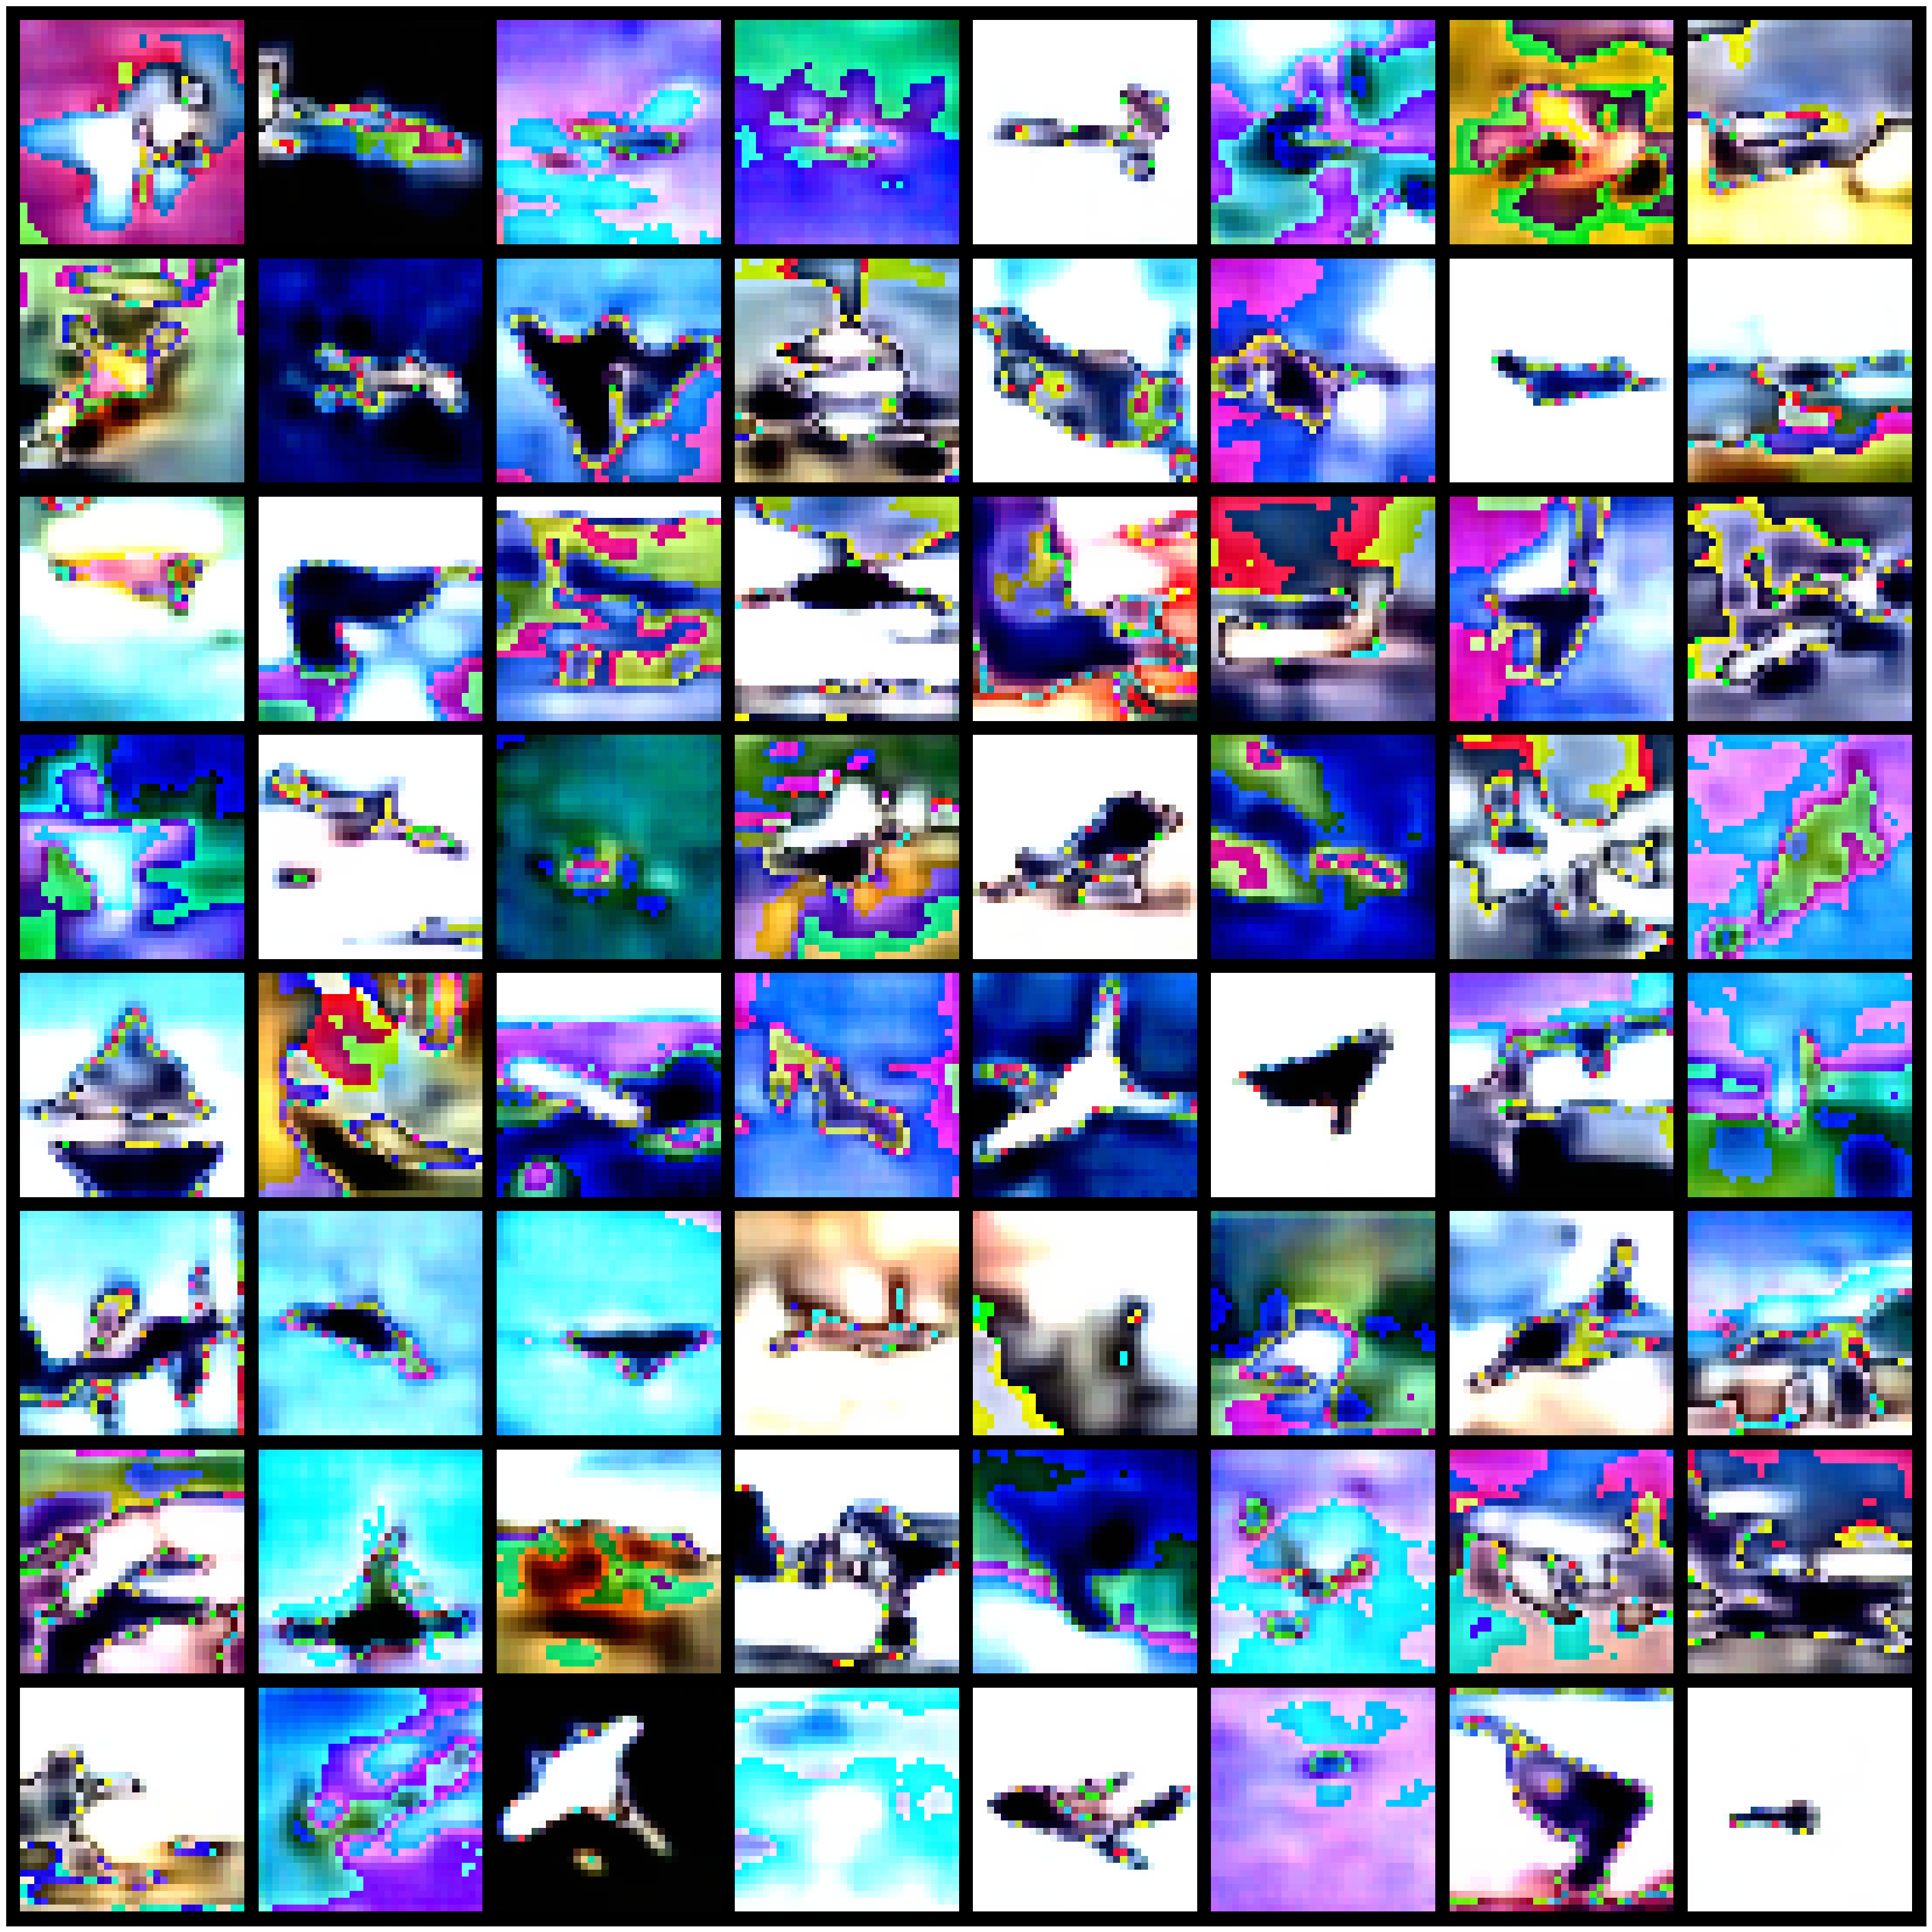

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons)
show(grid)

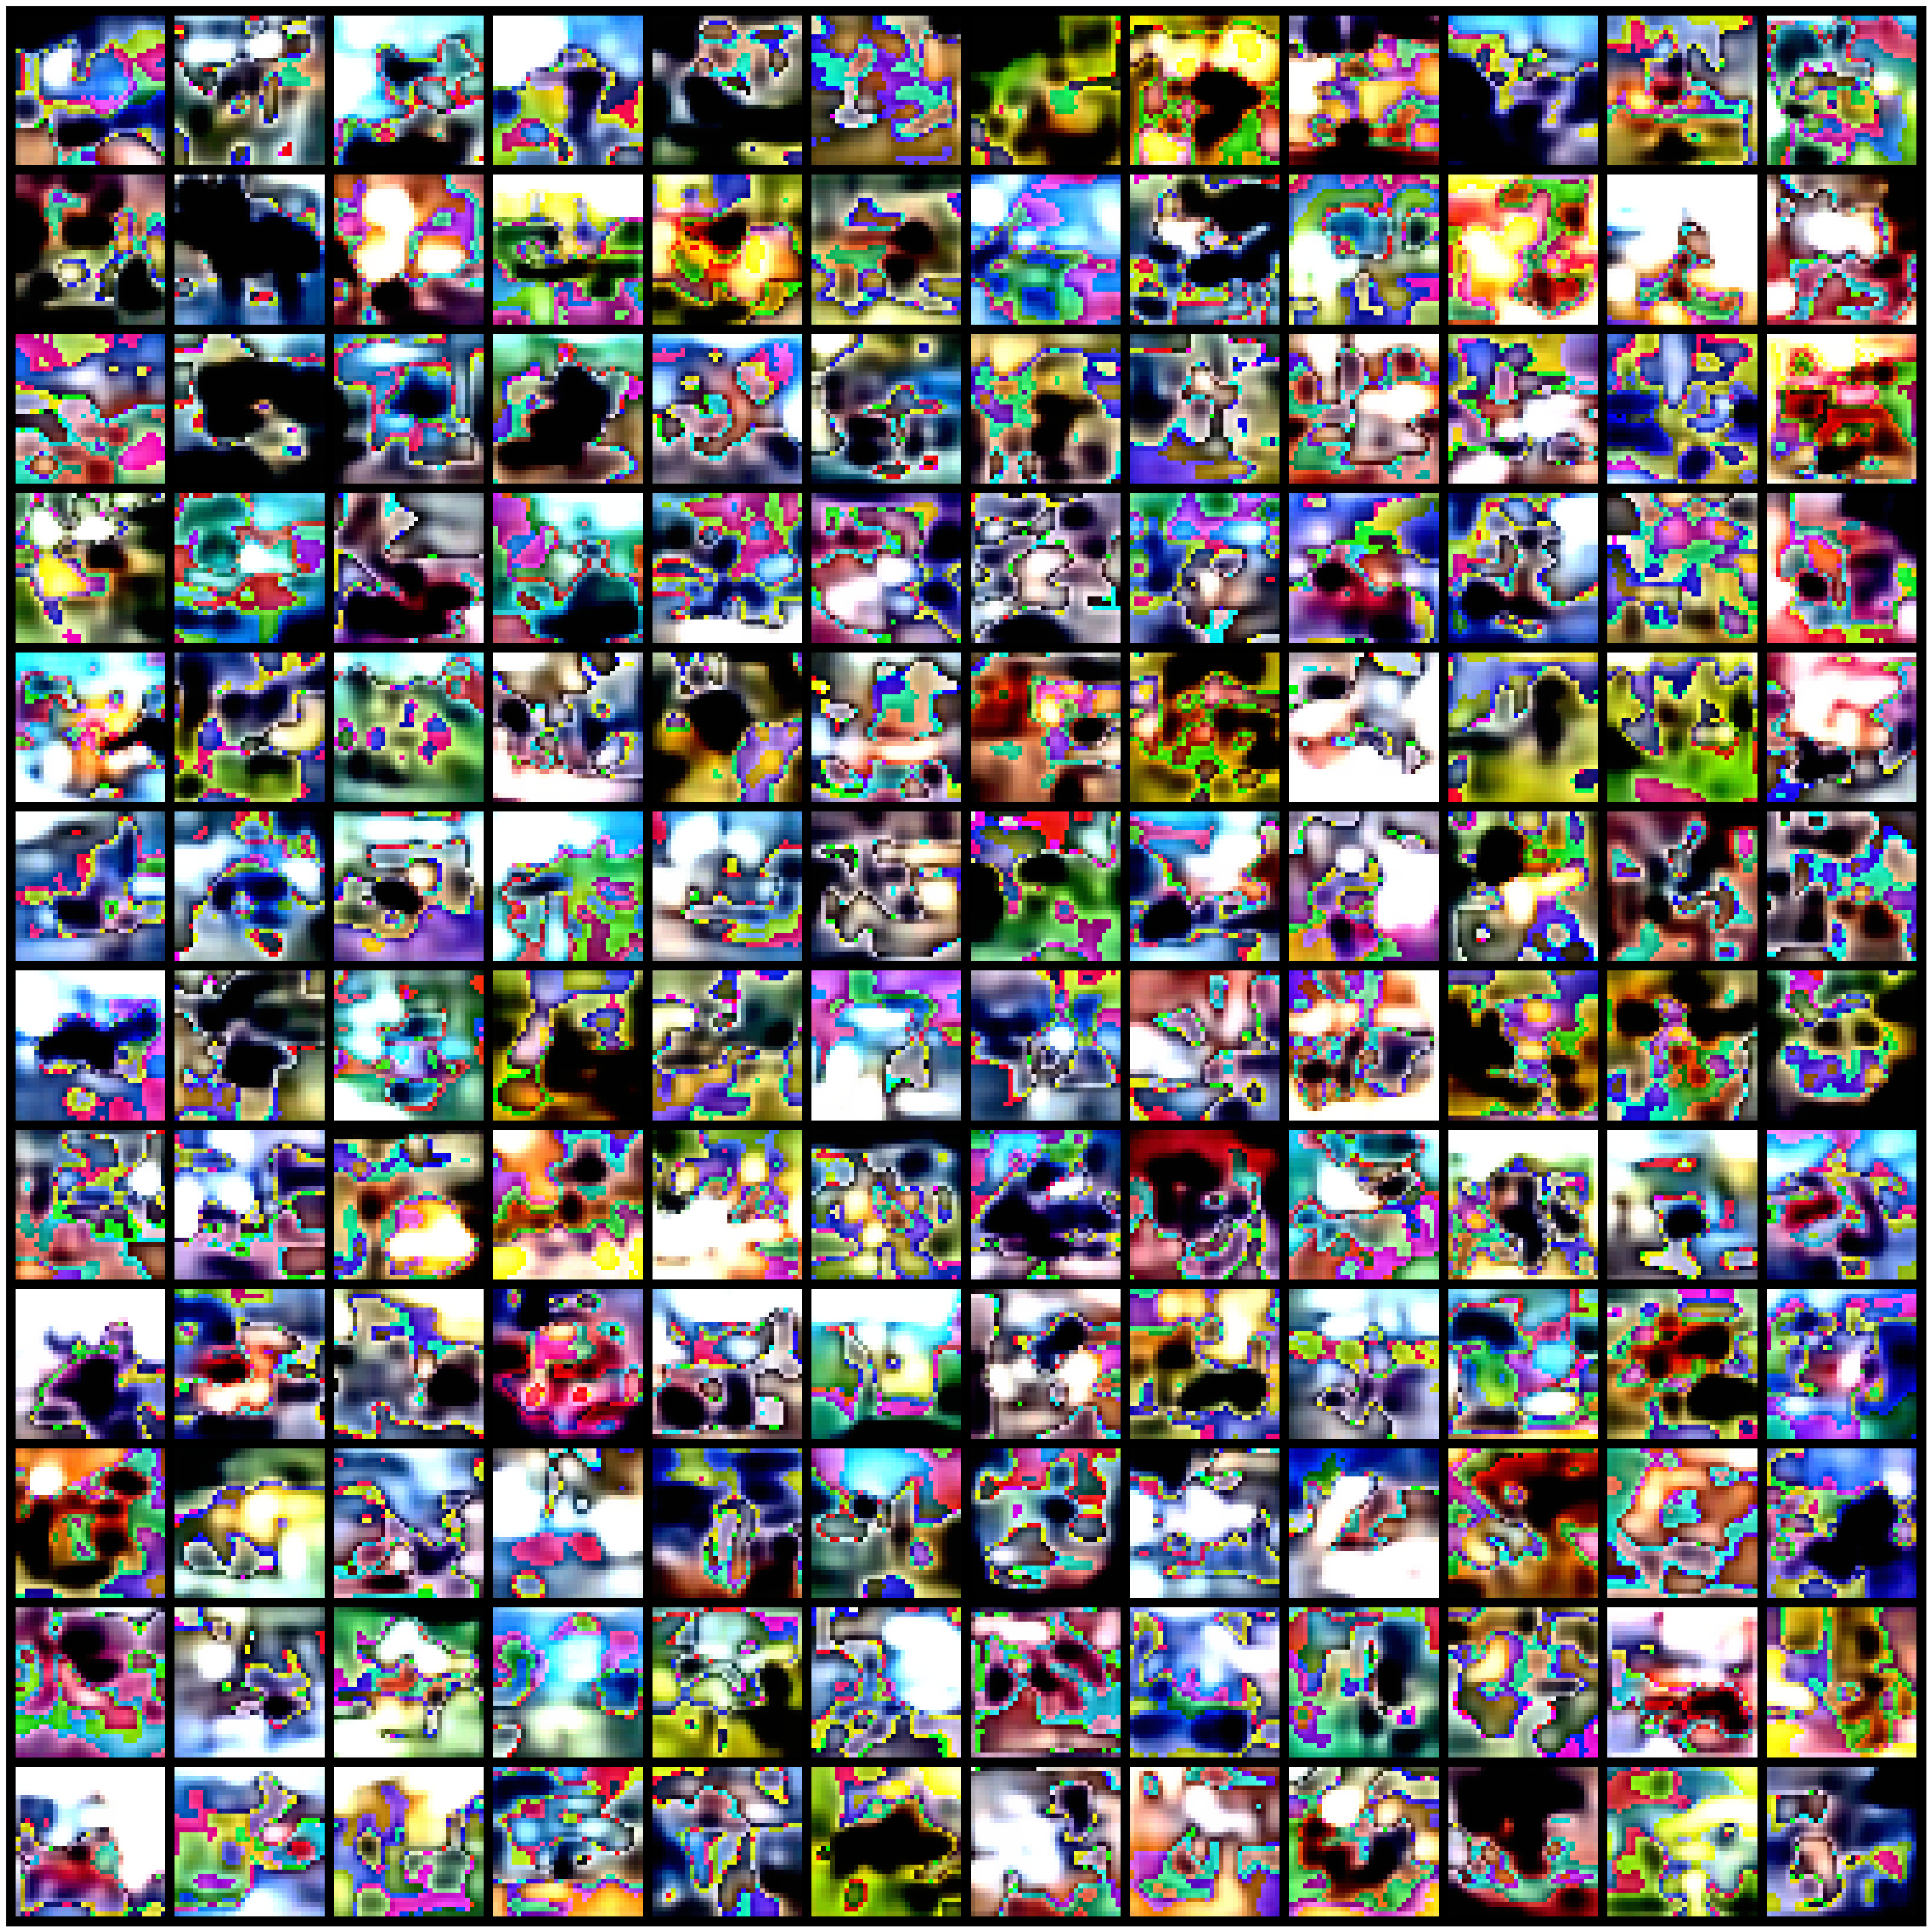

In [11]:
z = torch.randn(144, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)

In [12]:
attrs = trainset.attr_names[:-1]
print(attrs)
print(f"#Attr: {len(attrs)}")

AttributeError: 'ImageFolder' object has no attribute 'attr_names'

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=20, title=None):
    z_1 = autoencoder.get_latent(x_1)[0]
    z_2 = autoencoder.get_latent(x_2)[0]
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.permute(0, 2, 3, 1).to('cpu').detach().numpy()

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat
    fig, ax = plt.subplots(figsize=(15, 2))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [ ]:
model.eval()
with torch.no_grad():
    x, y = next(iter(train_dl))
    for idx_x in range(3):
        for idx_y in range(9, 12):
            x_1 = x[y[:, idx_x] == 1][1].to(device).unsqueeze(0)
            x_2 = x[y[:, idx_y] == 1][1].to(device).unsqueeze(0)

            interpolate(model, x_1, x_2, n=20, title = f"{attrs[idx_x]} and {attrs[idx_y]}")

            # plt.close()